In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from glob import glob

In [2]:
path = "../data/train/binary"
files = glob(f"{path}/*.csv.gz")
df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)
# df = df[df["Label"] == 0]
print(df.shape)
feature_cols = [c for c in df.columns if c != 'Label']
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

label_values_counts = len(df["Label"].unique())

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Label"])

(1469979, 89)


In [3]:
class DataFrameDataset(Dataset):
    def __init__(self, df, target_column):
        self.features = df.drop(columns=[target_column]).values.astype(np.float32)
        self.labels = df[target_column].values.astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx])
        if self.labels is not None:
            y = torch.tensor(self.labels[idx])
            return x, y
        else:
            return x

BATCH_SIZE = 100
train_dataset = DataFrameDataset(train_df, target_column='Label')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = DataFrameDataset(val_df, target_column='Label')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
# BATCH_SIZE = 100

# trainval_data = MNIST("./test_data", 
#                    train=True, 
#                    download=True, 
#                    transform=transforms.ToTensor())

# train_size = int(len(trainval_data) * 0.8)
# val_size = int(len(trainval_data) * 0.2)
# train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

# train_loader = DataLoader(dataset=train_data,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True,
#                           num_workers=0)

# val_loader = DataLoader(dataset=val_data,
#                         batch_size=BATCH_SIZE,
#                         shuffle=True,
#                         num_workers=0)

# print("train data size: ",len(train_data))   #train data size:  48000
# print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
# print("val data size: ",len(val_data))   #val data size:  12000
# print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120


In [5]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

# image_numpy = images.detach().numpy().copy()
# plt.imshow(image_numpy[0,0,:,:], cmap='gray')


images_size: torch.Size([100, 88])
label: tensor([0, 2, 3, 0, 0, 0, 0, 0, 3, 0])


In [6]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(88, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 88)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev


In [7]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss


In [8]:
z_dim = 2
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 88).to(torch.float32)
    output, z, ave, log_dev = model(input)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'\rEpoch: {epoch+1:3d}, loss: {loss: 04.4f}', end='')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 88).to(torch.float32)
      output, z, ave, log_dev = model(input)

      loss = criterion(output, input, ave, log_dev)
      history["val_loss"].append(loss)
      
    print(f' -> val_loss: {loss: 0.4f}')
  
  scheduler.step()


Epoch:   1, loss:  1104.0383 -> val_loss:  926.7284
Epoch:   2, loss:  1064.5887 -> val_loss:  985.3477
Epoch:   3, loss:  876.32248 -> val_loss:  904.8416
Epoch:   4, loss:  958.92192 -> val_loss:  898.2880
Epoch:   5, loss:  1011.0800 -> val_loss:  903.7723
Epoch:   6, loss:  1069.4663 -> val_loss:  904.4542
Epoch:   7, loss:  1014.2185 -> val_loss:  889.9003
Epoch:   8, loss:  1186.1720 -> val_loss:  876.6500
Epoch:   9, loss:  1031.7650 -> val_loss:  867.7839
Epoch:  10, loss:  1028.3551 -> val_loss:  884.0570
Epoch:  11, loss:  1016.0298 -> val_loss:  877.7459
Epoch:  12, loss:  1040.2781 -> val_loss:  888.6378
Epoch:  13, loss:  1011.1549 -> val_loss:  895.3022
Epoch:  14, loss:  991.37088 -> val_loss:  893.1569
Epoch:  15, loss:  1141.2788 -> val_loss:  903.2394
Epoch:  16, loss:  963.73748 -> val_loss:  909.2583
Epoch:  17, loss:  1007.7125 -> val_loss:  877.8542
Epoch:  18, loss:  987.56595 -> val_loss:  864.6666
Epoch:  19, loss:  852.31206 -> val_loss:  867.3523
Epoch:  20, 

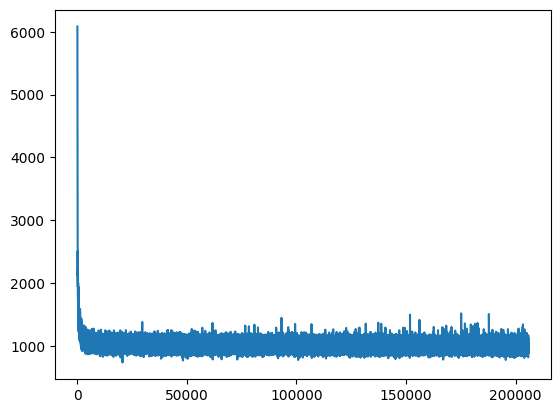

In [9]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)


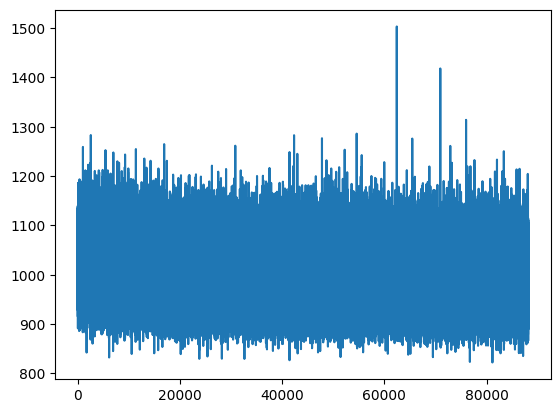

In [10]:
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)


In [11]:
ave_tensor = torch.cat(history["ave"])
log_var_tensor = torch.cat(history["log_dev"])
z_tensor = torch.cat(history["z"])
labels_tensor = torch.cat(history["labels"])
print(ave_tensor.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor.size())   #torch.Size([9600, 100, 2])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)   #(9600, 100, 2)
print(log_var_np.shape)   #(9600, 100, 2)
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)


torch.Size([20579700, 2])
torch.Size([20579700, 2])
torch.Size([20579700, 2])
torch.Size([20579700])
(20579700, 2)
(20579700, 2)
(20579700, 2)
(20579700,)


In [12]:
label_values_counts

10

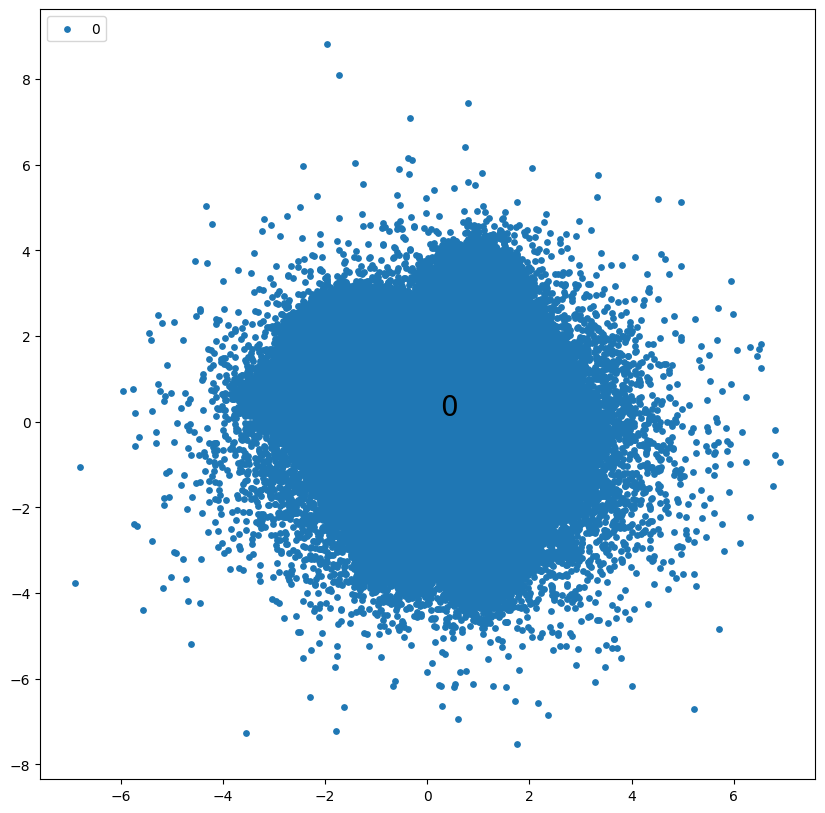

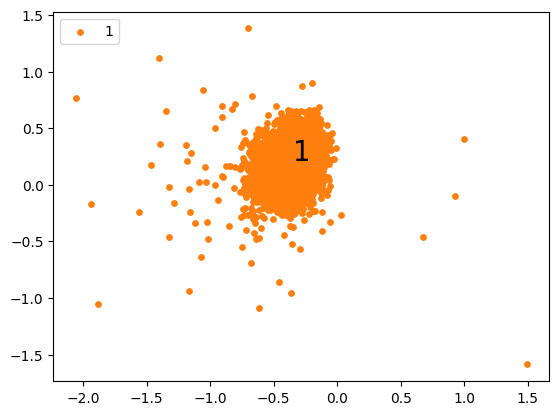

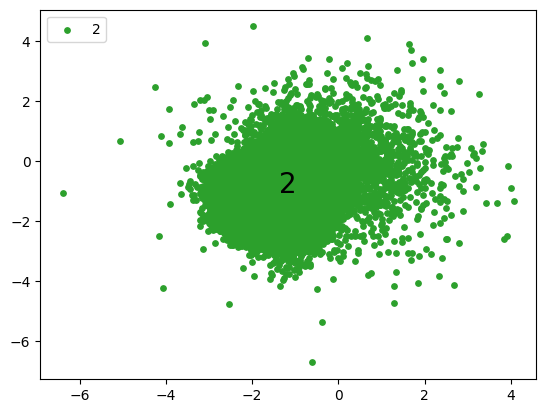

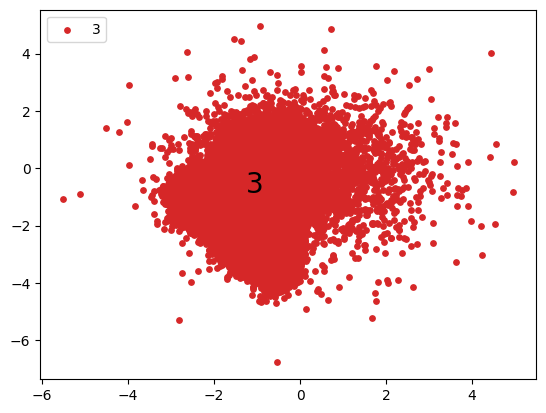

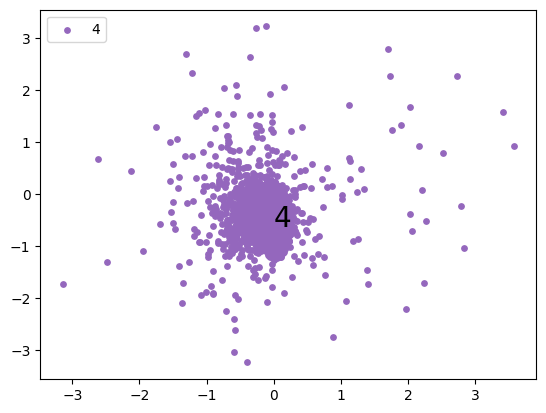

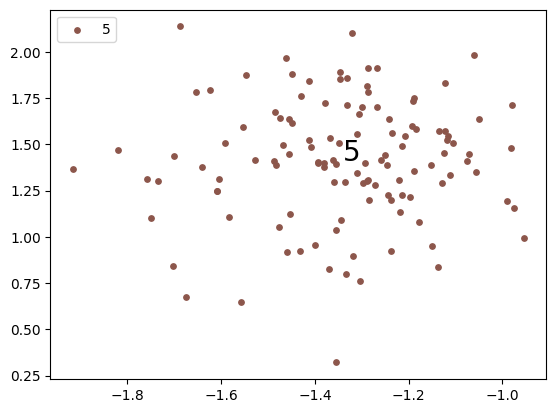

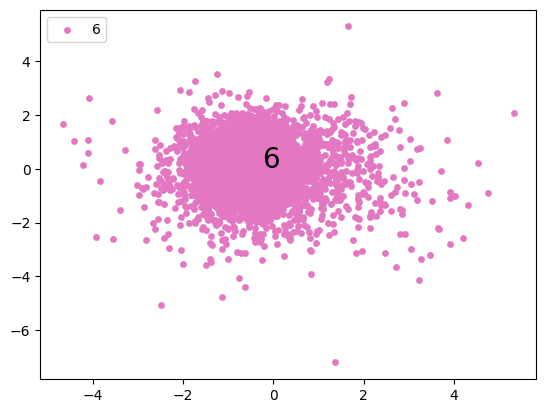

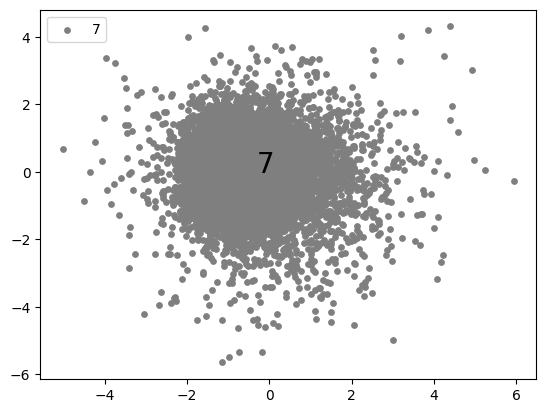

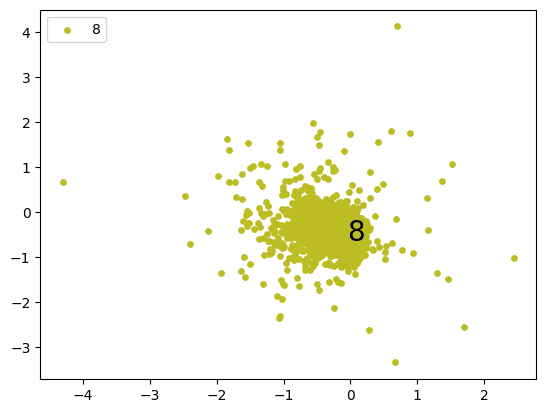

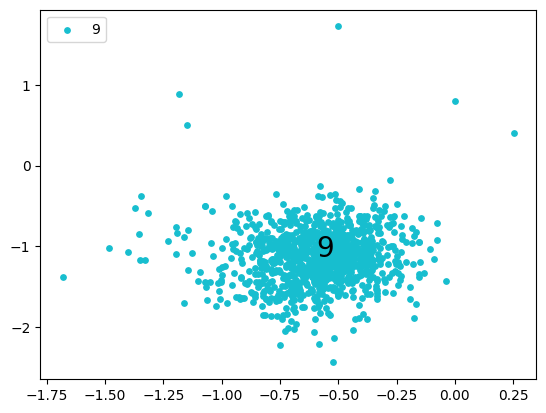

In [13]:
map_keyword = "tab10"
cmap = plt.get_cmap(map_keyword)

plt.figure(figsize=[10,10])
for label in range(label_values_counts):
    x = z_np[labels_np == label, 0]
    y = z_np[labels_np == label, 1]
    plt.scatter(x, y, color=cmap(label/label_values_counts), label=label, s=15)
    if len(x) > 0 and len(y) > 0:
        plt.annotate(label, xy=(np.mean(x), np.mean(y)), size=20, color="black")
    plt.legend(loc="upper left")
    plt.show()

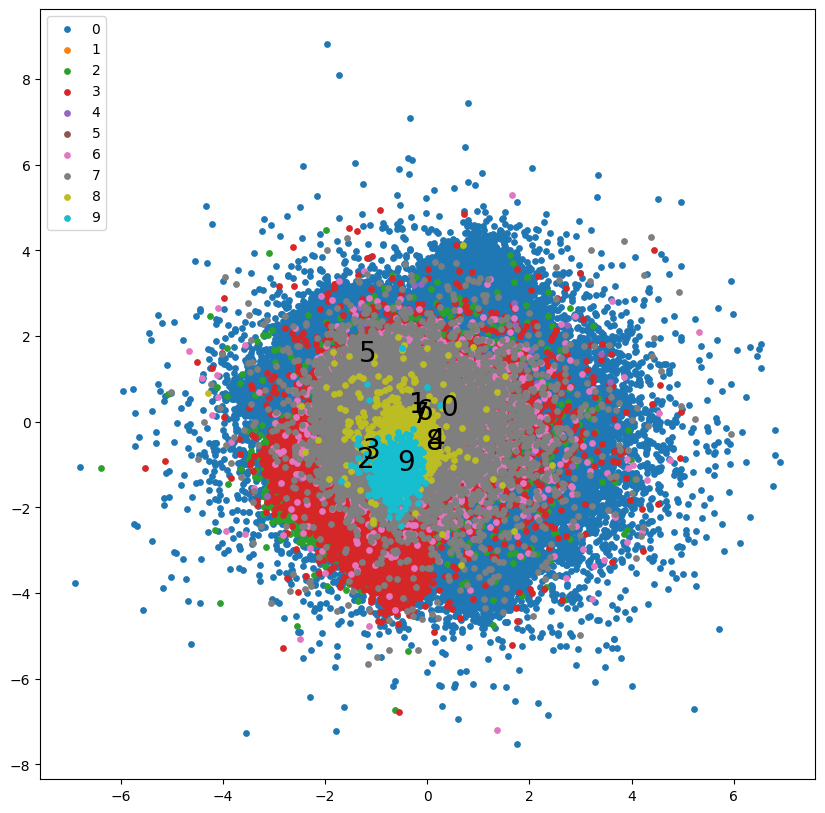

In [14]:
batch_num = 9580
plt.figure(figsize=[10,10])
for label in range(label_values_counts):
  x = z_np[labels_np == label, 0]
  y = z_np[labels_np == label, 1]
  plt.scatter(x, y, color=cmap(label/label_values_counts), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")
